# Post-processing

## Overview
This notebook shows a few examples of more advanced post-processing analysis:
- Profiles of temperature and heat flux predicted by the code at various front locations
- Amount of radiation throughout the domain

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

%matplotlib inline

## Read and visualise equilibrium
- SPR38 inner and outer, visualised.

<Axes: xlabel='$S_{\\parallel}$ (m from target)', ylabel='$B_{tot}$ (T)'>

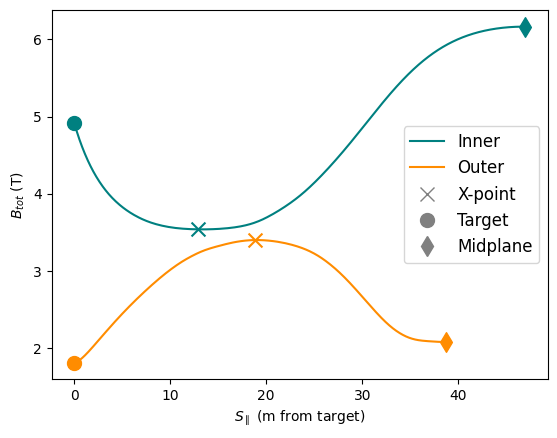

In [2]:
from fusiondls import MagneticGeometry, run_dls
from fusiondls.plot import plot_B_field_profile

filename = "eqb_store.pkl"
design = MagneticGeometry.read_design("eqb_store.pkl", "V10")
inner = design["iu"]
outer = design["ou"]
plot_B_field_profile(
    inner.S, inner.Btot, inner.Xpoint, outer.S, outer.Btot, outer.Xpoint
)

In [3]:
from fusiondls.AnalyticCoolingCurves import LfuncKallenbachAr

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 1e9,  # heat flux density at the x point
    "nu": 1e20,  # Upstream density (if constant)
    "nu0": 1e20,  # Upstream density (if constant)
    "cz0": 0.02,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbachAr,  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

In [4]:
store = {}

for side in ["ou", "iu"]:
    d = design[side]
    constants = constants_default.copy()  # Set settings to default
    # Solve at these parallel positions
    SparRange = np.linspace(0, d.S[d.Xpoint - 1], 5)

    if side == "iu":
        # Reduce power to 10% for the inner divertor to account for power sharing
        constants["qpllu0"] = constants_default["qpllu0"] * 0.1

    store[side] = run_dls(
        constants, d, SparRange, verbosity=0, control_variable="density"
    )

Solving...0.00...4.57...9.15...13.72...18.29...Complete in 2.3 seconds
Solving...0.00...3.14...6.27...9.41...12.54...Complete in 2.8 seconds


# Post-processing

## Temperature and heat flux profiles

FIXME: What are we plotting here? What are the different lines?

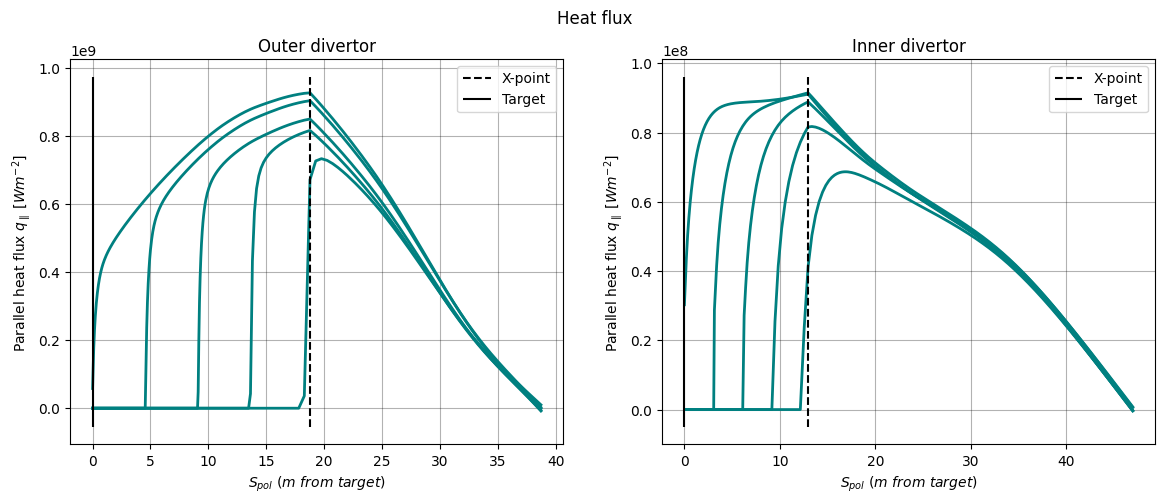

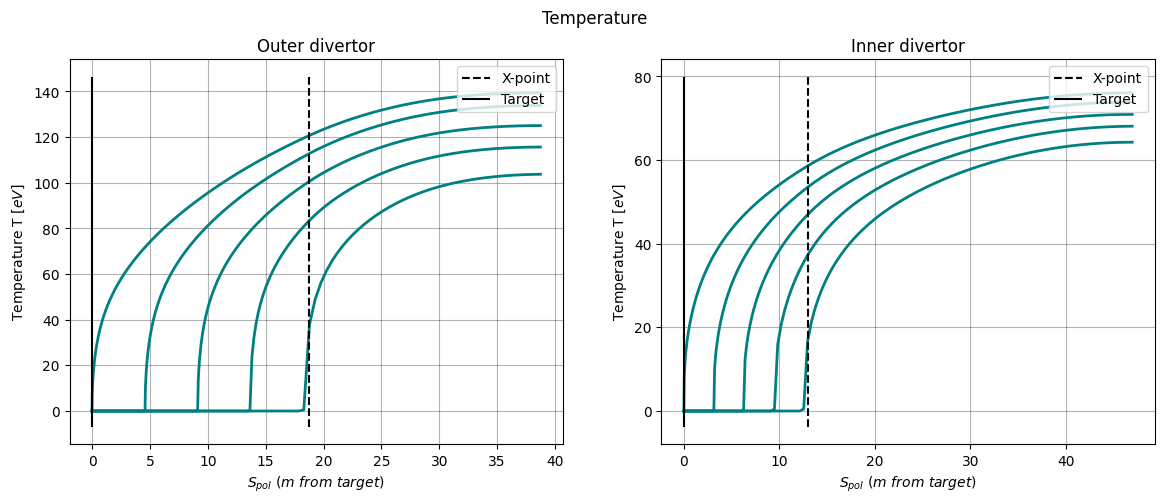

In [5]:
def plot_profiles(param, figtitle, ylabel):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(figtitle)

    for ax, side in zip(axes, ["ou", "iu"]):
        for point, _ in enumerate(SparRange):
            o = store[side]  # Result data
            ax.plot(o["Sprofiles"][point], o[param][point], linewidth=2, color="teal")

        ylim = ax.get_ylim()
        ax.vlines(
            design[side].Sx,
            ylim[0],
            ylim[1],
            label="X-point",
            color="black",
            linestyle="dashed",
        )
        ax.vlines(0, ylim[0], ylim[1], label="Target", color="black", linestyle="solid")
        ax.grid(color="black", alpha=0.3)
        ax.set_xlabel(r"$S_{pol}\ (m\ from\ target)$")
        ax.set_ylabel(ylabel)
        ax.legend(fontsize=10, loc="upper right")

    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")


plot_profiles(
    "Qprofiles", "Heat flux", r"Parallel heat flux $q_{\parallel}$ $[Wm^{-2}]$"
)
plot_profiles("Tprofiles", "Temperature", r"Temperature T $[eV]$")

## Temperature and radiation profiles
- Each line is a temperature profile for a given detachment front location.
- Each line is coloured by the radiated power in that particular location.
- Note how for positions near the target, the radiation quickly drops to 1% (two orders of magnitude below peak)
- And note how for positions near the X-point, there is still a good amount of radiation above the X-point.
- There is a sharp gradient near the detachment front where the colours drop off. This is due to very sharp temperature gradients there and the fact the cell exactly at the front location has a temperature determined by the target temperature setting (0.5eV by default) and therefore has no radiation. This is just a visual effect and goes away with higher mesh resolutions. It does not affect the answer - the code integrates across this properly.

Text(0.5, 1.0, 'Temperature profiles for scan of front locations')

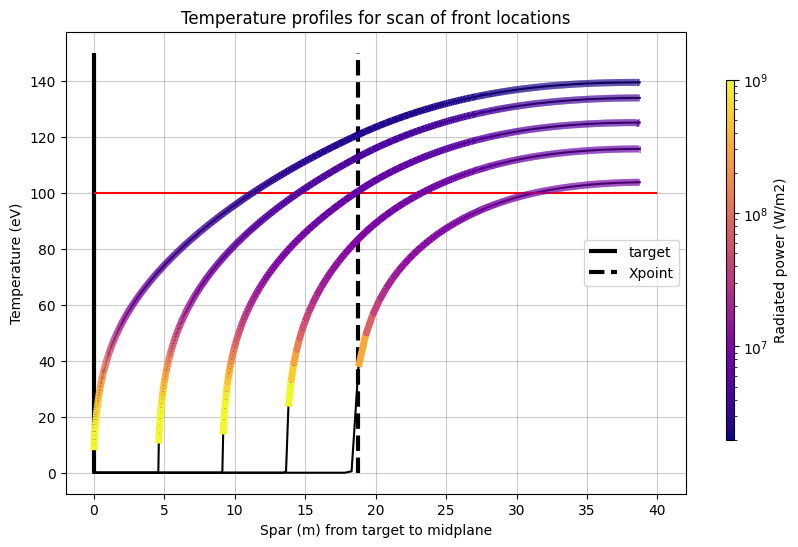

In [6]:
side = "ou"

fig, ax = plt.subplots(figsize=(8, 6))
o = store[side]

cmap = plt.get_cmap("plasma")

for S_profile, R_profile, T_profile in zip(
    o["Sprofiles"], o["Rprofiles"], o["Tprofiles"]
):
    ax.plot(S_profile, T_profile, color="black")

    points = np.array([S_profile, T_profile]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(2e6, 1e9)
    lc = LineCollection(segments, linewidth=5, cmap=cmap, norm=norm, zorder=10)
    lc.set_array(R_profile)
    line = ax.add_collection(lc)

ax.vlines(0, 0, 150, zorder=5, label="target", color="black", linewidth=3)
ax.vlines(
    design[side].Sx,
    0,
    150,
    zorder=5,
    label="Xpoint",
    color="black",
    linewidth=3,
    linestyle="dashed",
)
ax.hlines(100, 0, 40, color="red", zorder=5)

caxs = fig.add_axes([0.95, 0.2, 0.01, 0.6])
cb = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=caxs,
    label="Radiated power (W/m2)",
)

ax.legend(loc="center right")
ax.grid(color="black", alpha=0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")
ax.set_title("Temperature profiles for scan of front locations")

## Temperature and radiation profiles (radiation relative to peak)

Text(0, 0.5, 'Temperature (eV)')

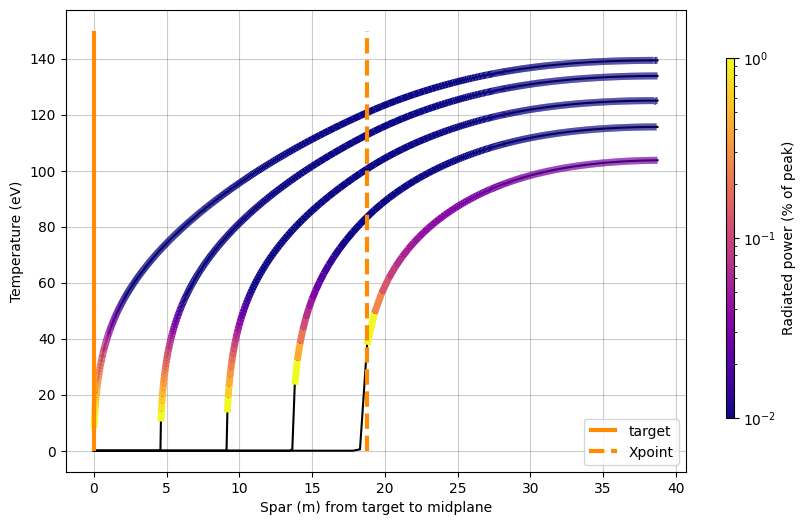

In [7]:
side = "ou"

fig, ax = plt.subplots(figsize=(8, 6))

o = store[side]

cmap = plt.get_cmap("plasma")

for S_profile, R_profile, T_profile in zip(
    o["Sprofiles"], o["Rprofiles"], o["Tprofiles"]
):
    ax.plot(S_profile, T_profile, color="black")

    points = np.array([S_profile, T_profile]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = mpl.colors.LogNorm(0.01, 1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=5)
    lc.set_array(np.array(R_profile) / np.nanmax(R_profile))
    line = ax.add_collection(lc)

ax.vlines(0, 0, 150, label="target", color="darkorange", linewidth=3)
ax.vlines(
    design[side].Sx,
    0,
    150,
    label="Xpoint",
    color="darkorange",
    linewidth=3,
    linestyle="dashed",
)

caxs = fig.add_axes([0.95, 0.2, 0.01, 0.6])
cb = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=caxs,
    label="Radiated power (% of peak)",
)

# ax.set_xlim(0,40)
ax.legend(loc="lower right")
ax.grid(color="black", alpha=0.2)
ax.set_xlabel("Spar (m) from target to midplane")
ax.set_ylabel("Temperature (eV)")